# Запуск Экспериментов в Azure ML

## 1. Соединение со своим Workspace

Импорт модулей:

In [1]:
import os

import azureml.core
from azureml.core import Workspace, Experiment, Dataset
from azureml.core.datastore import Datastore

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json

%matplotlib inline


# Check core SDK version number
print(f'SDK version: {azureml.core.VERSION}')

SDK version: 1.12.0


Создаем соединение со своим Workspace:

In [2]:
ws = Workspace.from_config()
print('Connected Workspace:', ws.name, ws.resource_group, ws.location, sep = '\n')

Connected Workspace:
ai-in-cloud-workspace
ai-in-cloud-workshop-rg
westeurope


## 2. Загрузка данных для Эксперимента

Воспользуемся данными загружеными на [прошлом лабораторном занятии](../module-3/azure-datastore.ipynb):

In [5]:
# Get uploaded data 
diabetes_ds = ws.datasets.get('diabetes_db')

data = diabetes_ds.to_pandas_dataframe()
data.sample(10)

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
6657,1451536,5,105,65,44,95,44.929578,0.140390,43,1
12306,1111564,0,74,83,50,36,18.809250,0.284085,43,0
13889,1109224,1,82,29,11,704,21.720773,0.744834,25,0
10543,1616966,1,150,82,26,48,21.701670,0.170924,21,0
14438,1711126,1,118,83,22,79,23.810404,0.147983,55,1
13392,1448413,8,122,67,22,201,36.199936,0.093652,62,1
4015,1128763,1,106,91,12,332,33.193670,0.187818,31,0
11692,1266232,1,74,61,8,49,45.712246,0.655630,22,0
10241,1997807,6,113,81,22,90,27.437465,0.115110,47,1
5156,1544434,8,169,81,54,60,30.196837,1.510411,21,1


## 3. Запуск Эксперимента

Создадим Эксперимент и залогируем основные данные об эксперименте, а также информацию о данных используемых в нем:

In [6]:
# Create an Azure ML experiment
experiment = Experiment(workspace=ws, name='diabetes-experiment')

# Create an interactive run
run = experiment.start_logging()
run.tag('diabetes')
run.tag('azure-ml-workshop')

run.log('Dataset dimension', f'{data.shape[0]}x{data.shape[1]}')
run.log('Yet another important fact', 'Think about it')

print(f'Starting experiment {experiment.name}...')

Starting experiment diabetes-experiment...


Проанализируем количество пациентов с диабетом и без и залогируем результаты:

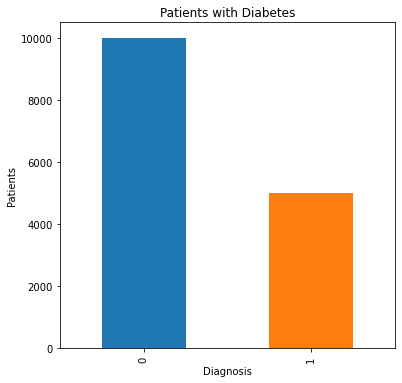

In [7]:
# Plot and log the count of diabetic vs non-diabetic patients
diabetic_counts = data['Diabetic'].value_counts()

fig = plt.figure(figsize=(6,6))
ax = fig.gca()    

diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()
run.log_image(name = 'label distribution', plot = fig)

# log distinct pregnancy counts
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

Plot a __correlation matrix__

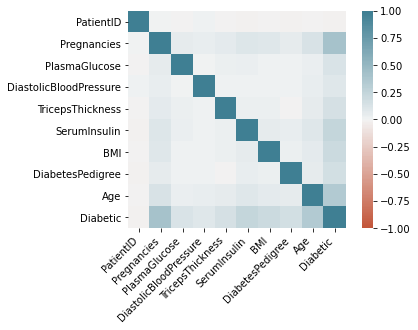

In [20]:
import seaborn as sns

corr = data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

run.log_image(name='correlation matrix', plot=ax.get_figure())

Plot boxplots:

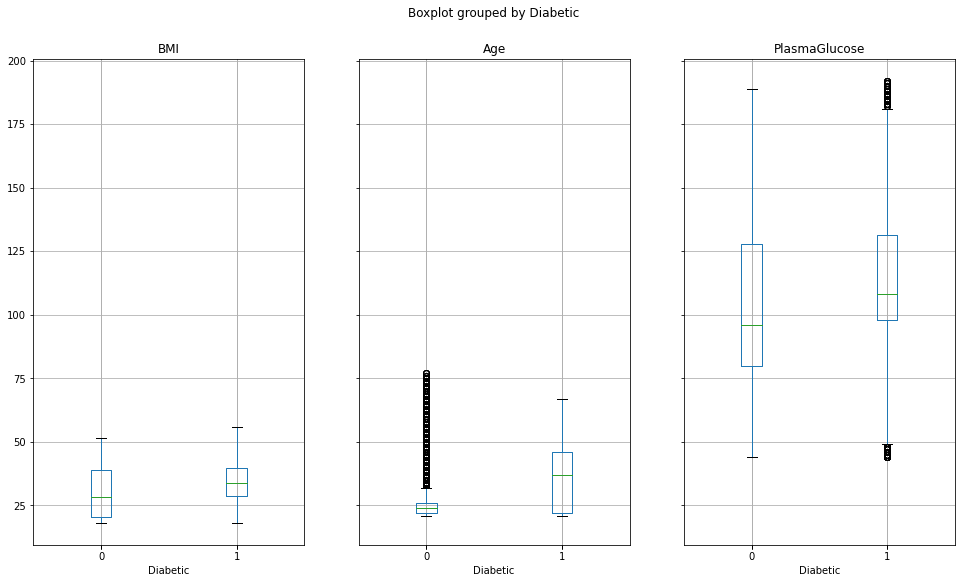

In [23]:
bxp = data.boxplot(column=['BMI', 'Age', 'PlasmaGlucose'], by='Diabetic', layout=(1, 3), figsize=(16, 9))

Посчитаем описательные статистики датасета и залогируем результаты:

In [12]:
# Log summary statistics for numeric columns
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat = keys[index], value = values[index])

Сохраним 100 случайных строк из дасета в выходные данные Эксперимента:

In [13]:
data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream = './sample.csv')

Завершим эксперимент:

In [14]:
# Complete the run
run.complete()

## 4. Просмотр результатов Эксперимента

Детали эксперимента:

In [15]:
details = run.get_details()
print(details)

{'runId': '58a1e0fd-1d34-4e8f-987a-4449b57e07b1', 'target': 'local', 'status': 'Completed', 'startTimeUtc': '2020-09-15T15:50:56.027401Z', 'endTimeUtc': '2020-09-15T15:56:18.846852Z', 'properties': {'azureml.git.repository_uri': 'https://github.com/codez0mb1e/AI-in-cloud-workshop.git', 'mlflow.source.git.repoURL': 'https://github.com/codez0mb1e/AI-in-cloud-workshop.git', 'azureml.git.branch': 'azure-ml-ru', 'mlflow.source.git.branch': 'azure-ml-ru', 'azureml.git.commit': 'cad1a6b964de7e9504d728fbd453480ae7ba6bc9', 'mlflow.source.git.commit': 'cad1a6b964de7e9504d728fbd453480ae7ba6bc9', 'azureml.git.dirty': 'True', 'ContentSnapshotId': 'f5ad6a7c-a098-4937-929d-92d16eb852ce'}, 'inputDatasets': [], 'outputDatasets': [], 'logFiles': {}}


Метрики эксперимента:

In [16]:
metrics = run.get_metrics()
print(json.dumps(metrics, indent=2))

{
  "Dataset dimension": "15000x10",
  "Yet another important fact": "Think about it",
  "label distribution": "aml://artifactId/ExperimentRun/dcid.58a1e0fd-1d34-4e8f-987a-4449b57e07b1/label distribution_1600185071.png",
  "pregnancy categories": [
    1,
    0,
    8,
    3,
    4,
    11,
    2,
    6,
    7,
    9,
    10,
    13,
    5,
    12,
    14
  ],
  "PlasmaGlucose": {
    "stat": [
      "count",
      "mean",
      "std",
      "min",
      "25%",
      "50%",
      "75%",
      "max"
    ],
    "value": [
      15000.0,
      107.85686666666666,
      31.98197465181073,
      44.0,
      84.0,
      104.0,
      129.0,
      192.0
    ]
  },
  "DiastolicBloodPressure": {
    "stat": [
      "count",
      "mean",
      "std",
      "min",
      "25%",
      "50%",
      "75%",
      "max"
    ],
    "value": [
      15000.0,
      71.22066666666667,
      16.75871603653161,
      24.0,
      58.0,
      72.0,
      85.0,
      117.0
    ]
  },
  "TricepsThickness": {
   

Выходные данные:

In [21]:
files = run.get_file_names()
print(json.dumps(files, indent=2))

[
  "Correlation matrix_1600185561.png",
  "label distribution_1600185071.png",
  "outputs/sample.csv"
]


Визуализируем данные с помощью виджета:

In [18]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Перейдите по сссылке, которая появилась в виджете, чтобы просмотеть результаты Эксперимента на протале Azure ML.